<a href="https://colab.research.google.com/github/TottiPuc/Sandwich-Prior_superResolution/blob/christian/E2E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/') 
drive.mount("/content/gdrive/", force_remount=True)

In [ ]:
%cd "/content/gdrive/MyDrive/Colab Notebooks/sandwich/sandwich1/"
%ls

In [3]:
from __future__ import print_function
import matplotlib.pyplot as pl
from skimage.metrics import peak_signal_noise_ratio

import numpy as np

import torch
import torch.optim

import scipy.io
from skimage.measure import compare_psnr
from models.downsampler import *
from models.unet import UNet
from models.unet_up import UNet_up
from models.skip import skip
from torch.nn import functional as F
from models.MAIN import *


from utils.sr_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

In [ ]:
p_factor = 4 #2  # spatial factor  # to evaluate []
q_factor = 4 #16  # Number of spectral bands

data_set = 'Salinas'
LR = 0.001   # learning rate parameter to evaluate #[0.005, 0.001, 0.0005]
reg_noise_std = 0  # try 0 0.03 0.05 0.08

reg_loss=[1.0,1.0,1.0,1.0]

name_save = 'Dataset_'+data_set+'_p_factor_'+str(p_factor)+'_q_bands_'+str(q_factor)+'_LR_'+str(LR)+'_perturbed_'+str(reg_noise_std)+'_loss_'+str(reg_loss)
print(name_save)

Path = 'results/'+name_save
try:
  os.stat(Path)
except:
  os.mkdir(Path)

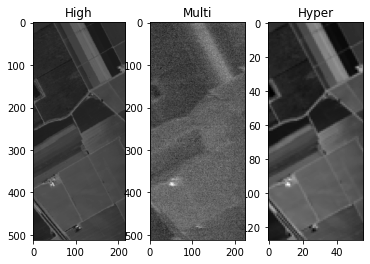

In [5]:
import cv2
width = 224
height = 512
dim = (width, height)

file_name  = 'data/'+data_set+'.mat'
imgs = scipy.io.loadmat(file_name)
#plot band
band = 23
HRi = imgs['salinas'][:,:,:192]
HRr = cv2.resize(HRi, dim, interpolation = cv2.INTER_AREA)
#HR_i = (HRr-np.mean(HRr))/(np.std(HRr))
#HR_o = (HRi-np.min(HRi))/(np.max(HRi)-np.min(HRi))
HR_o = (HRr-np.min(HRr))/(np.max(HRr)-np.min(HRr))
HR = HR_o.transpose(2,0,1)
HR = torch.from_numpy(HR).type(dtype)
HR = HR[None, :].cuda()




# Low resolution Image
KERNEL_TYPE='lanczos2'
downsampler = Downsampler(n_planes=HR.shape[1], factor=p_factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)
img_hyper = torch.from_numpy(downsampler(HR).detach().cpu().numpy()).type(dtype)
mostr = img_hyper.detach().cpu().squeeze().numpy().transpose(1, 2, 0)
#plt.subplot(1,3,1),plt.imshow(HRr[:,:,band],cmap='gray'),plt.title('High')
plt.subplot(1,3,1),plt.imshow(HRi[:,:,band],cmap='gray'),plt.title('High')
plt.subplot(1,3,3),plt.imshow(mostr[:, :, band],cmap='gray'),plt.title('Hyper')

dw_spectral = spectral_blurring(Input_band=192,factor=q_factor,type='decimation')
img_LR_var = torch.from_numpy(dw_spectral(HR).detach().cpu().numpy()).type(dtype)
mostr = img_LR_var.detach().cpu().squeeze().numpy().transpose(1, 2, 0)
plt.subplot(1,3,2),plt.imshow(mostr[:, :, 0],cmap='gray'),plt.title('Multi')
plt.show()


img_Multi = img_LR_var

In [6]:
method =    '2D'
pad   =     'reflection'
pad2 = 'same'
OPT_OVER =  'net'

show_every = 100

tv_weight = 0.0
OPTIMIZER = 'adam'
#OPTIMIZER = 'rmsprop'
num_iter = 20000
save_every = int(num_iter/5)

In [7]:
def get_params1(opt_over, net, net2, net3,net4,net_input, downsampler=None):
    '''Returns parameters that we want to optimize over.

    Args:
        opt_over: comma separated list, e.g. "net,input" or "net"
        net: network
        net_input: torch.Tensor that stores input `z`
    '''
    opt_over_list = opt_over.split(',')
    #print(opt_over_list)
    params = []
    
    for opt in opt_over_list:
    
        if opt == 'net':
            params += [x for x in net.parameters() ]
            params += [y for y in net2.parameters() ]
            params += [z for z in net3.parameters() ] # adicionadas por mi
            params += [w for w in net4.parameters() ]
        elif  opt=='down':
            assert downsampler is not None
            params = [x for x in downsampler.parameters()]
        elif opt == 'input':
            net_input.requires_grad = True
            params += [net_input]
        else:
            assert False, 'what is it?'
            
    return params


In [8]:
net_inputH1 = img_Multi.type(dtype).detach()
netH1 = skip(img_Multi.shape[1], HR.shape[1],
           num_channels_down = [128]*5,
           num_channels_up =   [128]*5,
           num_channels_skip =    [4]*5,
           filter_size_up = 3,filter_size_down = 3,  filter_skip_size=1,
           upsample_mode='bilinear', # downsample_mode='avg',
           need1x1_up=False,
           need_sigmoid=False, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
netH2 = UNet( HR.shape[1], img_hyper.shape[1],feature_scale=2).cuda()

In [9]:
net_inputH3 = img_hyper.type(dtype).detach()
netH3 = UNet_up( HR.shape[1], img_hyper.shape[1]).cuda()
netH4 = skip(HR.shape[1],img_Multi.shape[1], 
           num_channels_down = [128]*5,
           num_channels_up =   [128]*5,
           num_channels_skip =    [4]*5,
           filter_size_up = 3,filter_size_down = 3,  filter_skip_size=1,
           upsample_mode='bilinear', # downsample_mode='avg',
           need1x1_up=False,
           need_sigmoid=False, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

In [10]:
def closure():
    global i, net_inputH1,net_inputH3

    if reg_noise_std > 0:
        net_inputH1 = net_input_savedH1 + (noiseH1.normal_() * reg_noise_std)
        net_inputH3 = net_input_savedH3 + (noiseH3.normal_() * reg_noise_std)
    #H1
    out_HR_H1 = netH1(net_inputH1) # entre Multi sale  high resultion
    #H3
    out_HR_H3 = netH3(net_inputH3) # entre hyper sale  high resultion
    
    out_HR = torch.add(out_HR_H1, out_HR_H3)
    
    
    # decimation
    out_LR = downsampler(out_HR) # entra high sale hyper
    out_spectral =  dw_spectral(out_HR) # entra high sale multi

    #H2
    out_BRH2 = netH2(out_HR) # sale hyper
    #H4
    out_BRH4 = netH4(out_HR) # sale multi


    #loss functions
    #total_loss  = reg_loss[0] * mse(out_LR, img_hyper)
    #total_loss += reg_loss[1] * mse(out_spectral, img_Multi)
    #total_loss += 0.50 * mse(out_LR ,out_BR )
    #total_loss += reg_loss[2] * mse(img_hyper ,out_BRH2)
    #total_loss += reg_loss[3] * mse(img_Multi ,out_BRH4)


    #total_loss  = reg_loss[0] * mse(out_LR, img_hyper)#original
    #total_loss += reg_loss[1] * mse(out_spectral, img_Multi)#orginal
    total_loss  = reg_loss[0] * mse(out_BRH2, img_hyper)
    total_loss += reg_loss[1] * mse(out_BRH4, img_Multi)
    #total_loss += 0.50 * mse(out_LR ,out_BR )
    total_loss += reg_loss[2] * mse(out_LR ,out_BRH2)
    total_loss += reg_loss[3] * mse(out_spectral ,out_BRH4)
    #total_loss += reg_loss[2] * mse(img_hyper ,out_BRH2) #original
    #total_loss += reg_loss[3] * mse(img_Multi ,out_BRH4) #original

    if tv_weight > 0:
        total_loss += tv_weight * tv_loss(out_HR)

    total_loss.backward()

    # Log
    psnr_HR = peak_signal_noise_ratio(HR_o.astype(np.float32),  out_HR.detach().cpu().squeeze().numpy().transpose(1, 2, 0)) 
    psnr_LRH = peak_signal_noise_ratio(img_hyper.detach().cpu().squeeze().numpy().transpose(1, 2, 0), out_BRH2.detach().cpu().squeeze().numpy().transpose(1, 2, 0))
    psnr_LRM = peak_signal_noise_ratio(img_Multi[0].detach().cpu().numpy().transpose(1, 2, 0), out_BRH4[0].detach().cpu().numpy().transpose(1, 2, 0))
    print('Iteration {}, PSNR_HR {:.2f},  PSNR_LRH {:.2f}, PSNR_LRM {:.2f}, total_loss {:.5f} '.format(i, psnr_HR, psnr_LRH,psnr_LRM, total_loss))

    # History
    psnr_history.append([psnr_LRH, psnr_HR])

    if i % show_every == 0:
        clear_output(wait=True)
        save_result(performance(HR_o.astype(np.float32),  out_HR.detach().cpu().squeeze().numpy().transpose(1, 2, 0)),name_save+'/results_HR')
        save_result(performance(img_hyper.detach().cpu().squeeze().numpy().transpose(1, 2, 0), out_BRH2.detach().cpu().squeeze().numpy().transpose(1, 2, 0)), name_save+'/results_LR')
        save_result(performance(img_Multi[0].detach().cpu().numpy().transpose(1, 2, 0), out_BRH4[0].detach().cpu().numpy().transpose(1, 2, 0)), name_save+'/results_LR')
        out_HR_np = out_HR.detach().cpu().squeeze().numpy().transpose(1, 2, 0)
        out_Y_np = out_BRH2.cpu().detach().numpy()[0].transpose(1, 2, 0)
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 15))
        ax1.imshow(HR_o[:, :, band], cmap='gray', vmin=0.0, vmax=0.5)
        ax2.imshow(np.clip(out_HR_np, 0, 1)[:, :, band], cmap='gray', vmin=0.0, vmax=0.5)
        plt.show()
        plt.imshow(out_Y_np[:, :, 5], cmap='gray', vmin=0.0, vmax=0.5)
        plt.show()

    if i % save_every == 0:
        out_HR_np = out_HR.detach().cpu().squeeze().numpy().transpose(1, 2, 0)
        scipy.io.savemat(Path+"/result_sr_2D_it%05d.mat" % (i), {'pred': np.clip(out_HR_np, 0, 1)})

    i += 1




In [ ]:
psnr_history = []
if os.path.isfile(Path+'/results_HR.txt'):
  remove(Path+'/results_HR.txt')
if os.path.isfile(Path+'/results_LR.txt'):
  remove(Path+'/results_LR.txt')
mse = torch.nn.MSELoss().type(dtype)
net_input_savedH1 = net_inputH1.detach().clone()
net_input_savedH3 = net_inputH3.detach().clone()
noiseH1 = net_inputH1.detach().clone()
noiseH3 = net_inputH3.detach().clone()

i = 0
p = get_params1(OPT_OVER, netH1, netH3, netH2,netH4, [net_inputH1, net_inputH3],)
optimize(OPTIMIZER, p, closure, LR, num_iter)